# Handwritten Image Recognition with Keras and MNIST 
![logo](keras.png) ![mnist](mnist.png)

## References:

* [Google Codelab tutorial](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0)
* http://neuralnetworksanddeeplearning.com/chap1.html
* https://keras.io/
* https://keras.io/examples/mnist_cnn/
* https://www.ics.uci.edu/~mohamadt/keras_mnist.html
* [3 Brown 1 Blue - What is a neural network](https://www.youtube.com/watch?v=aircAruvnKk)
* https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

### Imports

In [1]:
import numpy as np
import keras
import math

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from matplotlib import pyplot as plt
%matplotlib inline

print("Keras Version " + keras.__version__)

Using TensorFlow backend.
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)

Keras Version 2.3.1


/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '

### Set Batch Size and Number of Epochs

In [2]:
batch_size = 128
epochs = 10
num_classes =10

### Load and Prepare Data Set

* Loading the data set by calling the mnist.load_data() function.
* Storing the data into arrays for the test and train set, along with their labels.
* Casting arrays as type: float32
* One hot encoding transforms categorical labels to 0s and 1s in order for the model to interpret [One Hot Encoding](https://www.youtube.com/watch?v=v_4KWmkwmsU)


In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

# Loading data from training and test sets along with labels
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255 # Original data is uint8 (0-255). Scale to range [0,1]
X_test /= 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Viewing data

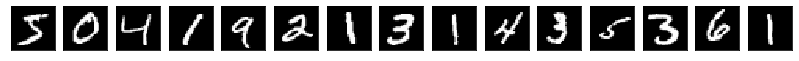

In [4]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(15):
    plt.subplot(1,15,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

## Sequential Convolutional 2D Keras Model

### Convolutional 2D
* Convolutional 2D neural networkds apply a series of learnable filters to the input image.
* A conv. layer is defined by the filter size, number of filters applied and the stride. 
* The input and output of the conv. layer each have 3 dimensions (width, height and number of channels), starting with input image (width, height, RGB).
* The width and height of the output can be adjusted by using a stride > 1 or with a max-pooling operation.

[Reference](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#9)

#### Notes:
* Adding more layers to allow the network to go deeper.
* Chaging 'sigmoid' to 'relu', reason being that even if the gradients coming from some neurons can be zero, there will always be others giving a clear non-zero gradient and training can continue at a good pace.
* Changing 'sgd' to 'adam' --> Better optimizer
* Adding dropout after each dense layer. Regularization technique.

##### Glossary:
* accuracy: metric used to keep track of during training.
* optimiser: algorithm used to update the weights.
* loss function: objective function being optimised. Using categorical crossentrophy as appropriate loss function for softmax output.
* filters: number of desired feature maps
* kernal_size: size of convolutional kernal. i.e. 5 --> 5 * 5 convolution
* strides: New layer maps will have size equal to previous layer maps divided by strides. Default 1 (currently using default).
* activation: Applied during forward propigation. Leaving blank results in no activation.
* [batch normalisation](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#12): tries to address problem of how neuron outputs are distributed relatively to neurons activation function.

In [5]:
model = Sequential()

model.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(24, (3, 3), activation='relu',
                 use_bias=False, padding='same'))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))

model.add(Conv2D(36, (6, 6), activation='relu',
                 use_bias=False, padding='same', strides=2))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))

model.add(Conv2D(48, (6, 6), activation='relu',
                 use_bias=False, padding='same', strides=2))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))

model.add(Flatten())

model.add(Dense(200, use_bias=False))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 24)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 24)        72        
_________________________________________________________________
dense_1 (Dense)              (None, 26, 26, 128)       3200      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 36)        165888    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 36)        108       
_________________________________________________________________
dense_2 (Dense)              (None, 13, 13, 128)      

### Learning Rate Schedule

* Starts the learning rate fast then decays exponentially

In [6]:
# Learning rate decay function
def learningrate_decay(epoch):
    return 0.01 * math.pow(0.666, epoch)

# learning rate schedule callback
learningrate_decay_callback = keras.callbacks.callbacks.LearningRateScheduler(learningrate_decay, verbose=True)



## Train the model

In [7]:
history = model.fit(X_train, Y_train, batch_size, epochs, verbose=1,
                    validation_data=(X_test, Y_test), callbacks=[learningrate_decay_callback])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
60000/60000 [==============================] - 398s 7ms/step - loss: 0.1721 - accuracy: 0.9517 - val_loss: 0.1023 - val_accuracy: 0.9708
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.00666.
60000/60000 [==============================] - 399s 7ms/step - loss: 0.0670 - accuracy: 0.9816 - val_loss: 0.0730 - val_accuracy: 0.9783
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.004435560000000001.
60000/60000 [==============================] - 393s 7ms/step - loss: 0.0405 - accuracy: 0.9887 - val_loss: 0.0405 - val_accuracy: 0.9882
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0029540829600000007.
60000/60000 [==============================] - 396s 7ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0304 - val_accuracy: 0.9915
Epoch 5/10

Epoch 00005: LearningRateScheduler settin

## Visualising predictions

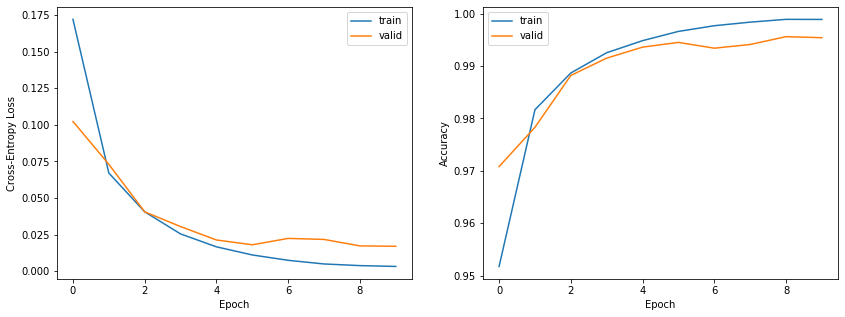

In [8]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Evaluate the performance

In [9]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test cross-entropy loss: %0.4f' % score[0])
print('Test accuracy: %0.4f' % score[1])

Test cross-entropy loss: 0.0170
Test accuracy: 0.9954


### Visualise and inspect the output

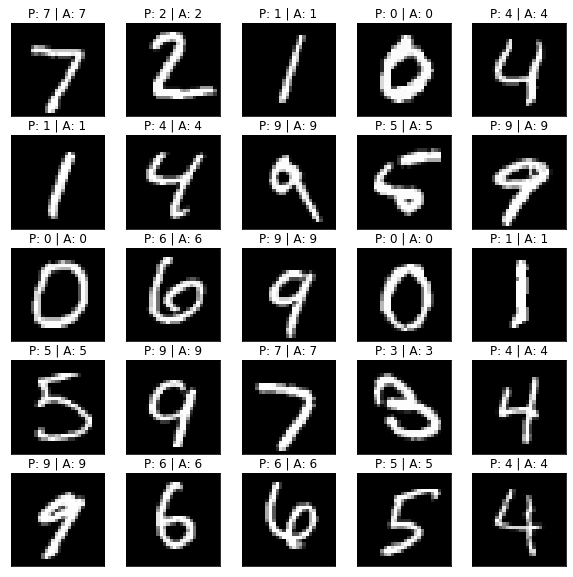

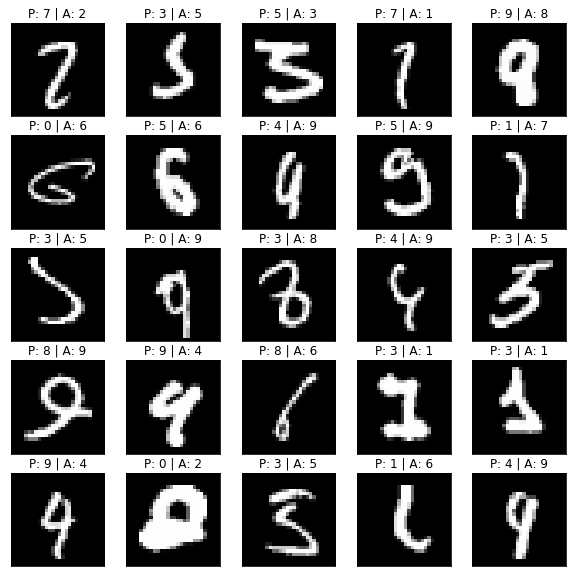

In [10]:
predicted_classes = model.predict_classes(X_test)
correct_indices   = np.nonzero(predicted_classes == Y_test.argmax(axis=-1))[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test.argmax(axis=-1))[0]

# Plot the correct images
plt.figure(1, figsize=(10,10))
for i, correct in enumerate(correct_indices[:25]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
   
    # Where P --> Predicted, A --> Actual
    plt.title("P: {} | A: {}".format(predicted_classes[correct], Y_test[correct].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])
    
# Plot the incorrect images
plt.figure(2, figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:25]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    
    # Where P --> Predicted, A --> Actual
    plt.title("P: {} | A: {}".format(predicted_classes[incorrect], Y_test[incorrect].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])